In [1]:
# Load Libraries
library(Seurat)
library(SeuratWrappers)
library(METAFlux)
library(sceasy)
library(reticulate)
library(dplyr)
library(data.table)
library(ggplot2)
library(gplots)
library(RColorBrewer)
library(purrr)
library(monocle3)
library(ComplexHeatmap)
library(circlize)

# Set Working Directory
setwd("../")

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: reticulate


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess



Attaching package: ‘purrr’


The following object is masked from ‘package:data.table’:

    transpose


Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following object is masked from ‘package:Seura

# Load Data

In [2]:
data <- readRDS("GBMProject/GBMOrganoid/Checkpoints/3_OrganoidPatient_Integrated.rds")
data

An object of class Seurat 
40124 features across 54275 samples within 1 assay 
Active assay: RNA (40124 features, 2000 variable features)
 7 layers present: data, counts, scale.data.TXP_PRO, scale.data.TXP_WT, scale.data.TXP_MES, scale.data.NeftelData, scale.data
 7 dimensional reductions calculated: pca, integrated.cca, umap.integrated.cca, integrated.rpca, umap.integrated.rpca, harmony, umap.harmony

In [3]:
meta_column = c()
length = ncol(data)
count = 1
while (count <= length) {
  if(data$celltype[count] %in% c("Macrophage","TCell")){
    value = "Immune"
  }
  else {
    value = as.character(data$celltype[count])
  }   
  meta_column = append(meta_column, value)
  count = count + 1
}

data$celltype2 = meta_column

In [2]:
# reload data
pro.flux <- readRDS("GBMProject/GBMOrganoid/METAFlux/METAFluxObject_PRO.rds")
mes.flux <- readRDS("GBMProject/GBMOrganoid/METAFlux/METAFluxObject_MES.rds")
pt.flux <- readRDS("GBMProject/GBMOrganoid/METAFlux/METAFluxObject_PT.rds")

flux <- readRDS("GBMProject/GBMOrganoid/METAFlux/METAFluxObject_Combined.rds")

# Fig 5ab - UMAP cell sources

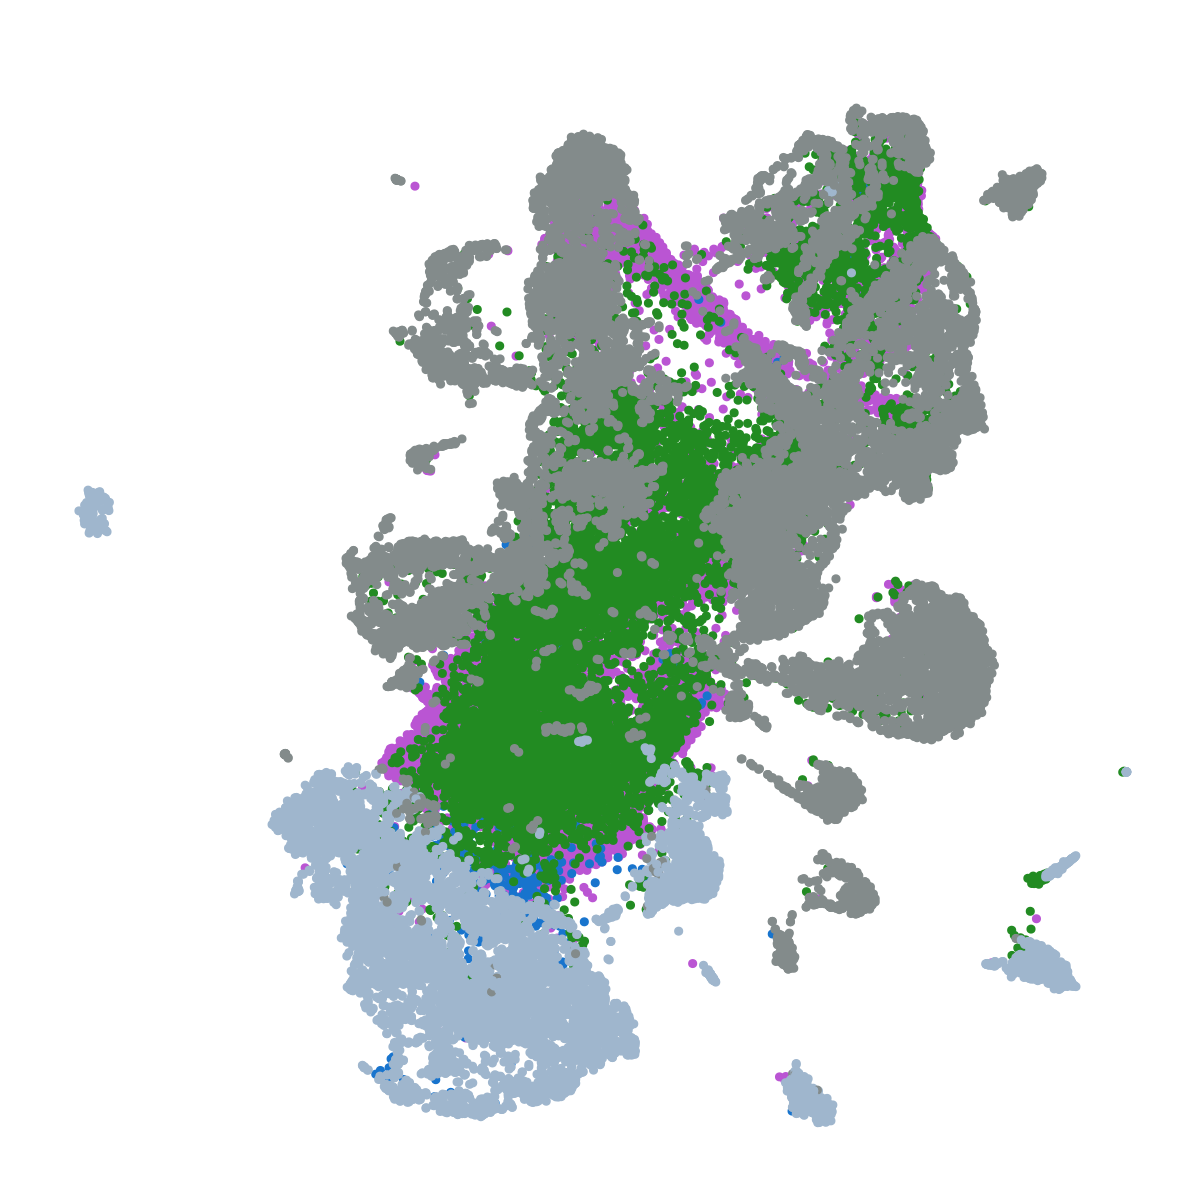

In [4]:
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(data, reduction = "umap.integrated.cca", group.by = "source", label = FALSE,
       cols=c("TXP_MES"="forestgreen","TXP_PRO"="mediumorchid","TXP_WT"="dodgerblue3","PT_Malignant"="azure4","PT_NM"="slategray3"), pt.size=1.5) + NoLegend() + NoAxes() + ggtitle("")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


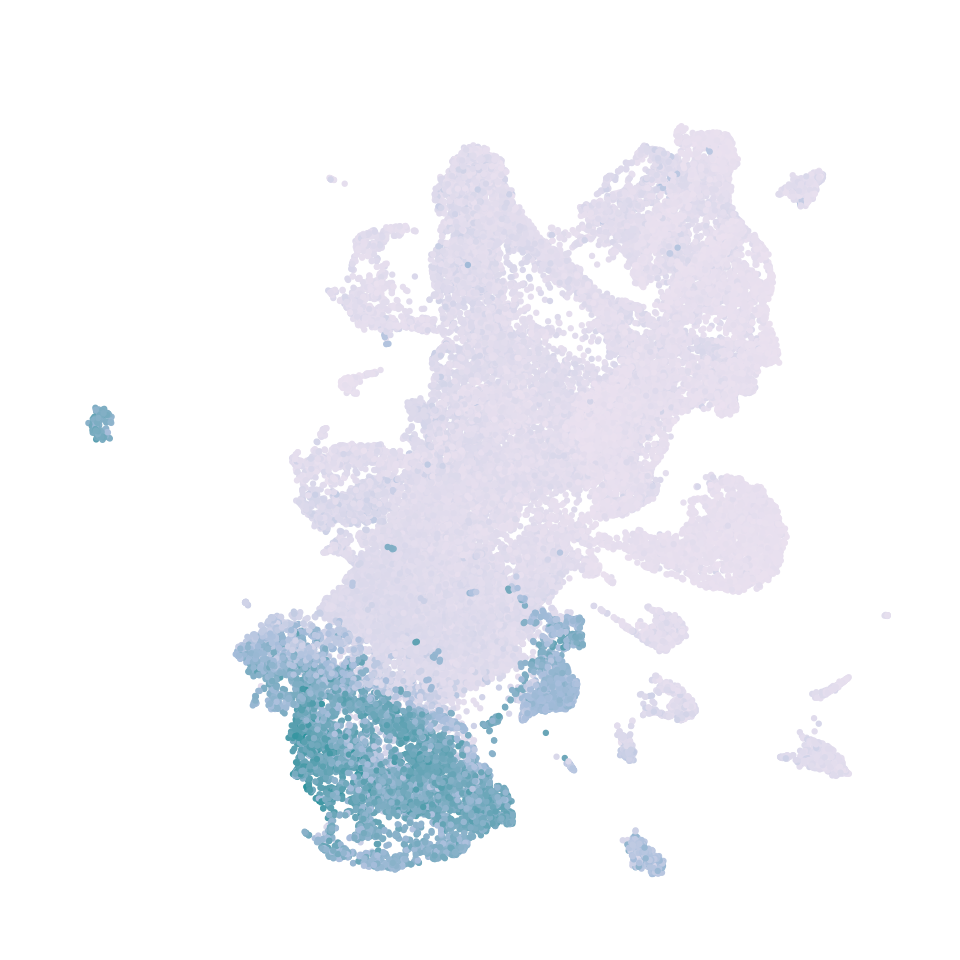

In [5]:
options(repr.plot.width = 8, repr.plot.height = 8)
FeaturePlot(data, features=c("ImmuneScore1"), ncol=1, label=FALSE, pt.size=0.75) + scale_colour_gradientn(colours = brewer.pal(n = 3, name = "PuBuGn")) + NoAxes() + ggtitle("") + NoLegend()

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


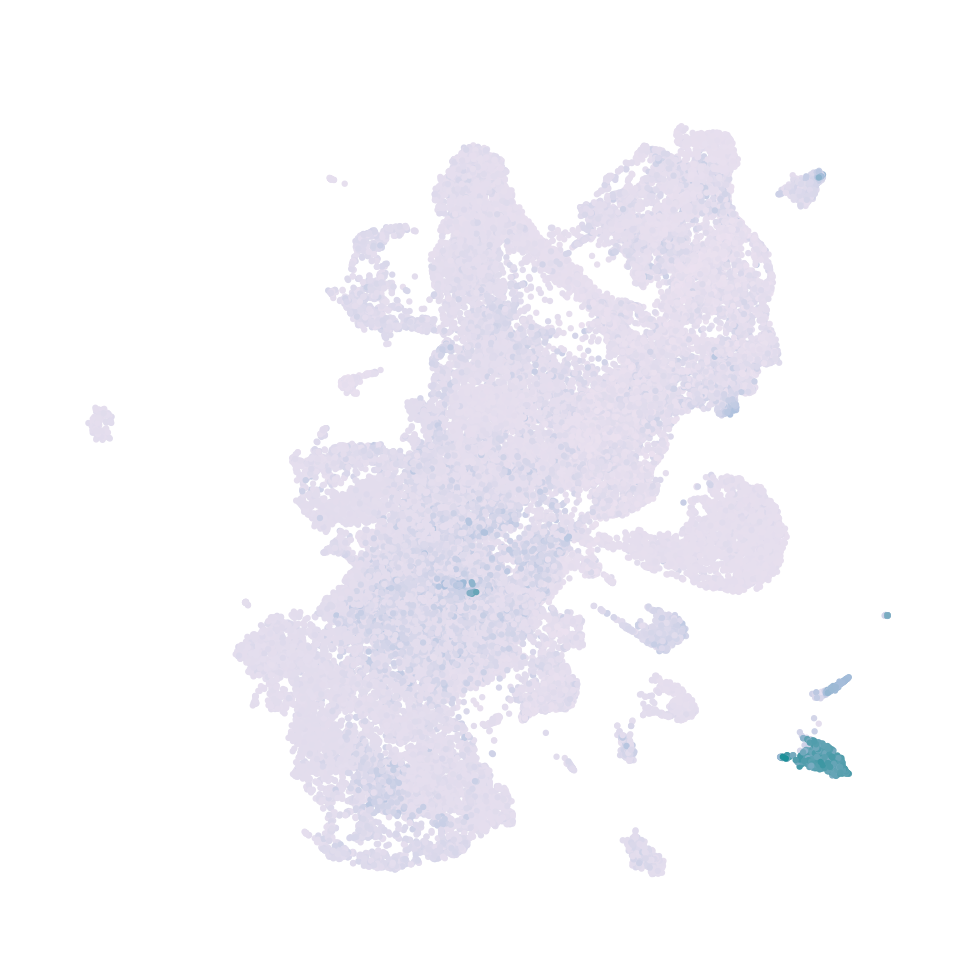

In [6]:
options(repr.plot.width = 8, repr.plot.height = 8)
FeaturePlot(data, features=c("OligScore1"), ncol=1, label=FALSE, pt.size=0.75) + scale_colour_gradientn(colours = brewer.pal(n = 3, name = "PuBuGn")) + NoAxes() + ggtitle("") + NoLegend()

# Fig 5c - Bar plot cell type proportions

In [14]:
Idents(data) <- 'celltype2'
levels(data)

[1] "1" "3"

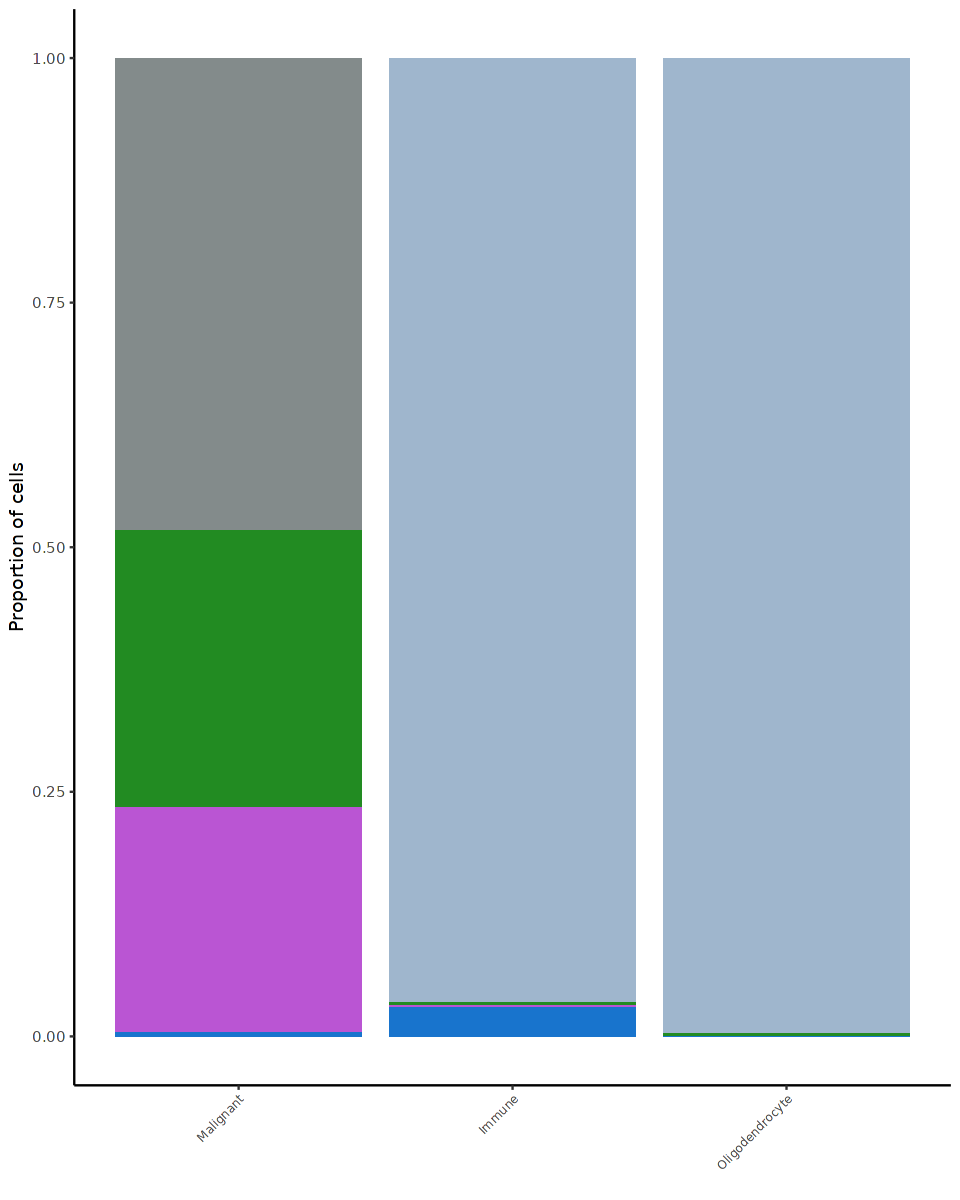

In [22]:
# Calculate cell type proportions
prop.celltype <- data.frame(prop.table(table(data$celltype2,data$source)))

colnames(prop.celltype) <- c("Celltype","Source", "Frac")
prop.celltype$Celltype <- as.character(prop.celltype$Celltype)
prop.celltype <- mutate(prop.celltype, Celltype = factor(prop.celltype$Celltype,levels=c("Malignant", "Immune", "Oligodendrocyte"))) 
#prop.celltype <- transmute(prop.celltype, = factor(prop.celltype,levels=c("Malignant", "Macrophage", "TCell", "Oligodendrocyte"))) 

prop.plot <- ggplot(prop.celltype, aes(fill=factor(Source), y=Frac, x=Celltype)) +
  geom_bar(position="fill", stat="identity", width = .9) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1, size = 7)) +
  labs(x = "", y = "Proportion of cells") +
  guides(fill = guide_legend(title="hto")) +
  scale_fill_manual(values=c("azure4","slategray3","forestgreen","mediumorchid","dodgerblue3")) + NoLegend()

options(repr.plot.width=8, repr.plot.height=10)
prop.plot

# Fig 5d - Pearson Correlation

In [8]:
## Pearson Correlation
dev.off()
Idents(data) <-"source"
DefaultAssay(data) <- 'RNA'
#txp.data$source <- factor(txp.data$source,levels=c('PT-NM', 'PT-Malignant', 'TXP-WT', 'TXP-PRO', 'TXP-MES'))

#txp.data<-FindVariableFeatures(txp.data,assay="RNA") 

av.exp <- AggregateExpression(data,features = VariableFeatures(data), assay="RNA",group.by ="source")
av.exp <- as.matrix(av.exp[[1]])
cor.exp <- cor(av.exp,method = "spearman")

null device 
          1

Names of identity class contain underscores ('_'), replacing with dashes ('-')
This message is displayed once every 8 hours.


In [9]:
cor.exp

,PT-Malignant,PT-NM,TXP-MES,TXP-PRO,TXP-WT
PT-Malignant,1.0000000,0.6215257,0.5977396,0.3664576,0.3133358
PT-NM,0.6215257,1.0000000,0.2945871,0.1094126,0.3299615
TXP-MES,0.5977396,0.2945871,1.0000000,0.6284085,0.4086988
TXP-PRO,0.3664576,0.1094126,0.6284085,1.0000000,0.6753962
TXP-WT,0.3133358,0.3299615,0.4086988,0.6753962,1.0000000


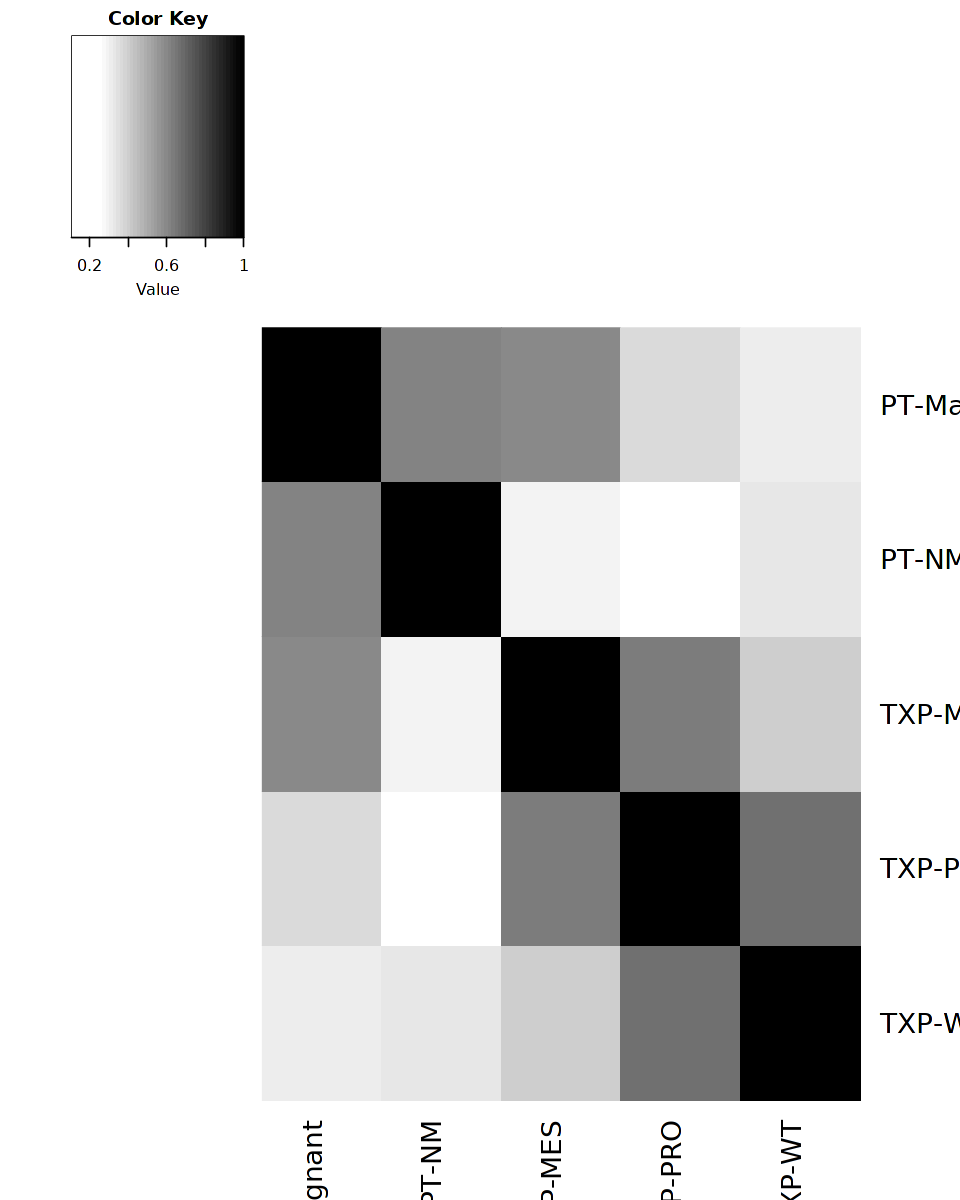

In [10]:
palette = colorRampPalette(c("White","Grey100","Grey80","Grey60","Grey40","Grey20","Grey0")) (50)
heatmap.2(x = cor.exp, col = palette,trace="none",density.info='none',dendrogram="none",Colv=FALSE,Rowv=FALSE)

# Fig 5f - Neftel States Plot

In [6]:
Idents(data) <- 'celltype'
malignant.cells <- subset(data, idents='Malignant')

Idents(malignant.cells) <- 'orig.ident'
malignant.cells <- subset(malignant.cells, idents='TXP_WT', invert=TRUE)

In [12]:
cell.names <- Cells(malignant.cells)

sample.id <- as.data.frame(malignant.cells$source) %>% mutate(cell.names)

Mes1.score <- as.data.frame(malignant.cells$Neftel_MES11) %>% mutate(cell.names)
Mes2.score <- as.data.frame(malignant.cells$Neftel_MES21) %>% mutate(cell.names)
AC.score <- as.data.frame(malignant.cells$Neftel_AC1) %>% mutate(cell.names)
OPC.score <- as.data.frame(malignant.cells$Neftel_OPC1) %>% mutate(cell.names)
NPC1.score <- as.data.frame(malignant.cells$Neftel_NPC11) %>% mutate(cell.names)
NPC2.score <- as.data.frame(malignant.cells$Neftel_NPC21) %>% mutate(cell.names)

Neftel.scores <- list(sample.id, Mes1.score, Mes2.score, AC.score, OPC.score, NPC1.score, NPC2.score) %>% reduce(full_join, by = "cell.names") %>% select(cell.names, everything())
colnames(Neftel.scores) <- c("cell.names", "Sample.ID", "Mes1.score", "Mes2.score", "AC.score", "OPC.score", "NPC1.score", "NPC2.score")

ERROR: Error: unable to find an inherited method for function ‘reduce’ for signature ‘x = "list"’


In [ ]:
Neftel.scores <- Neftel.scores %>% rowwise() %>% mutate(NPC.score = mean(c(NPC1.score, NPC2.score)), MES.score = mean(c(Mes1.score, Mes2.score)))
Neftel.scores <- select(Neftel.scores, -c(NPC1.score, NPC2.score, Mes1.score, Mes2.score))
Neftel.scores <- Neftel.scores %>% rowwise() %>% mutate(max.OPC.NPC = max(c(NPC.score, OPC.score)), max.MES.AC = max(c(AC.score, MES.score)))
Neftel.scores <- Neftel.scores %>% rowwise() %>% mutate(metaMod.diff = max.OPC.NPC - max.MES.AC)

# Calculate the difference of the OPC/NPC and AC/MES scores
Neftel.scores <- Neftel.scores %>% rowwise() %>% mutate(OPC.NPC.diff = (OPC.score - NPC.score), AC.MES.diff = (AC.score - MES.score))

# Add columns of y and x coordinates to plot
# For positive metaMod.diff (D), the y coordinate is equal to log2(|D| + 1), and -log2(|D| + 1) for negative values
# (See LeBlanc's https://github.com/vleblanc/GBM-PDE-paper/blob/main/scRNA_seq/fig5_gene_exp_signatures.R for more info)
Neftel.scores <- Neftel.scores %>% rowwise() %>% mutate(y.coord = ifelse(metaMod.diff > 0, log2(abs(metaMod.diff) +1), -log2(abs(metaMod.diff) + 1)))

# Similar calculations to determine x coordinates, with a nested ifelse to determine the main metamodule identity 
Neftel.scores <- Neftel.scores %>% rowwise() %>% mutate(x.coord = ifelse(metaMod.diff > 0, ifelse(OPC.NPC.diff > 0, -log2(abs(OPC.NPC.diff) + 1), log2(abs(OPC.NPC.diff) +1)), ifelse(AC.MES.diff > 0, -log2(abs(AC.MES.diff) +1), log2(abs(AC.MES.diff) + 1))))

# Create a list that contains the barcodes, SampleID, and respective coordinates
cell.coords <- select(Neftel.scores, "cell.names", "Sample.ID", "x.coord", "y.coord")

# Add cell state labels to the individual coordinates, with
# OPC = (-, +), NPC = (+, +), AC = (-, -), MES = (+, -) 
cell.coords <- cell.coords %>% rowwise() %>% 
  mutate(Neftel.label = ifelse(sign(x.coord) > 0, 
                               ifelse(sign(y.coord) > 0, "NPC", "MES"), 
                               ifelse(sign(y.coord) > 0, "OPC", "AC")))
head(Neftel.scores)
head(cell.coords)

In [ ]:
samples=unique(malignant.cells[["source"]]$source);
group.colors <- c("TXP_MES"="forestgreen","TXP_PRO"="mediumorchid","PT_Malignant"="azure4")

np1 <- ggplot(data = Neftel.scores, aes(x = .data[["x.coord"]], y = .data[["y.coord"]], color = .data[["Sample.ID"]])) + 
  geom_vline(xintercept = 0, show.legend = FALSE) + geom_hline(yintercept = 0, show.legend = FALSE)+ geom_point(alpha = 0.5, shape = 16, order=rev(samples)) + coord_cartesian(xlim = c(-2, 2), ylim = c(-2, 2)) +
  theme(axis.title.x=element_blank(),axis.title.y=element_blank(), panel.background = element_blank(), legend.key = element_blank()) + 
  geom_text(label = "MES", x = 3, y = -3, color = "black", angle = 45, fontface = "plain") + geom_text(label = "AC", x = -3, y = -3, color = "black", angle = -45, fontface = "plain") + 
  geom_text(label = "OPC", x = -3, y = 3, color = "black", angle = 45, fontface = "plain") + geom_text(label = "NPC", x = 3, y = 3, color = "black", angle = -45, fontface = "plain") +
  scale_color_manual(values=c("azure4","forestgreen","mediumorchid"))

np1

In [ ]:
options(repr.plot.width=15, repr.plot.height=5)
np2 <- np1 + facet_wrap(. ~ Sample.ID, ncol = 3) + theme(strip.background = element_blank(), strip.text.x = element_blank()) + NoLegend()
np2

In [ ]:
options(repr.plot.width=5, repr.plot.height=15)
np2 <- np1 + facet_wrap(. ~ Sample.ID, ncol = 1) + theme(strip.background = element_blank(), strip.text.x = element_blank()) + NoLegend()
np2

# Fig 5g - Violin Plot Cancer Modules

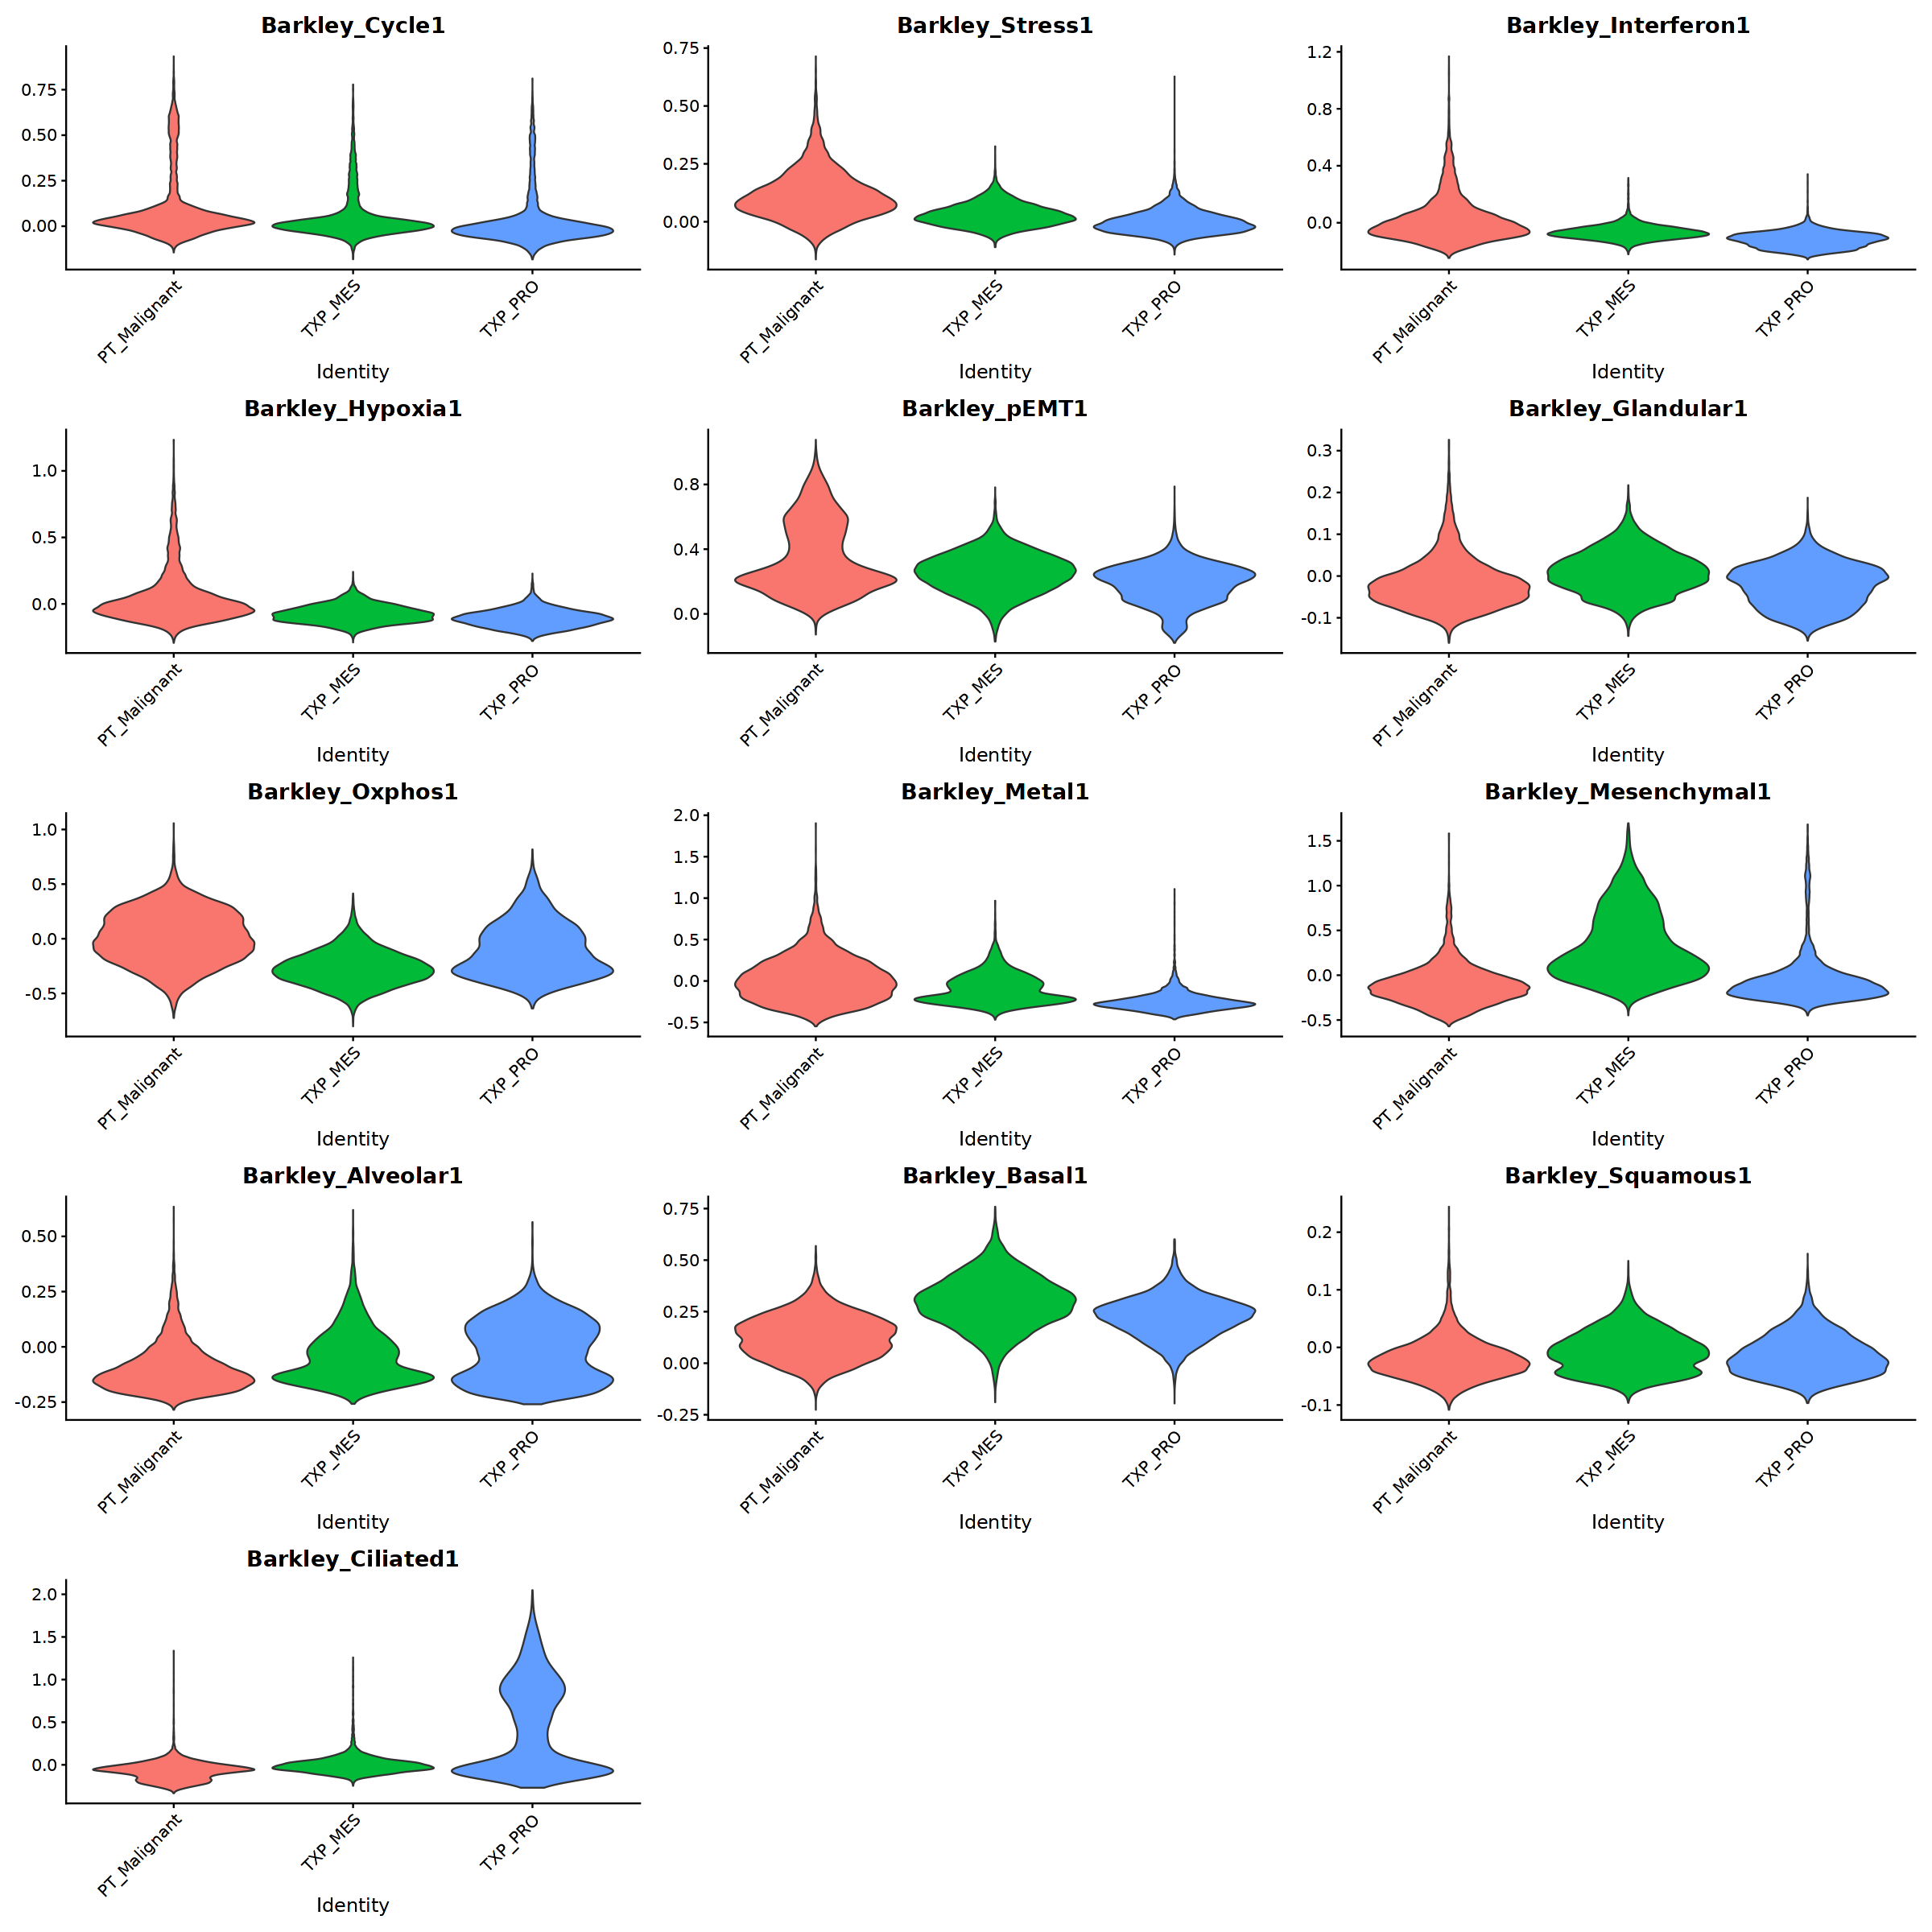

In [7]:
options(repr.plot.width=20, repr.plot.height=20)
VlnPlot(malignant.cells, group.by = "source", features = c('Barkley_Cycle1','Barkley_Stress1','Barkley_Interferon1',
                                                                'Barkley_Hypoxia1','Barkley_pEMT1','Barkley_Glandular1',
                                                                 'Barkley_Oxphos1','Barkley_Metal1','Barkley_Mesenchymal1',
                                                                 'Barkley_Alveolar1','Barkley_Basal1','Barkley_Squamous1',
                                                           'Barkley_Ciliated1'), 
            ncol = 3, pt.size=0) #+ NoLegend() + NoAxes() + ggtitle("")

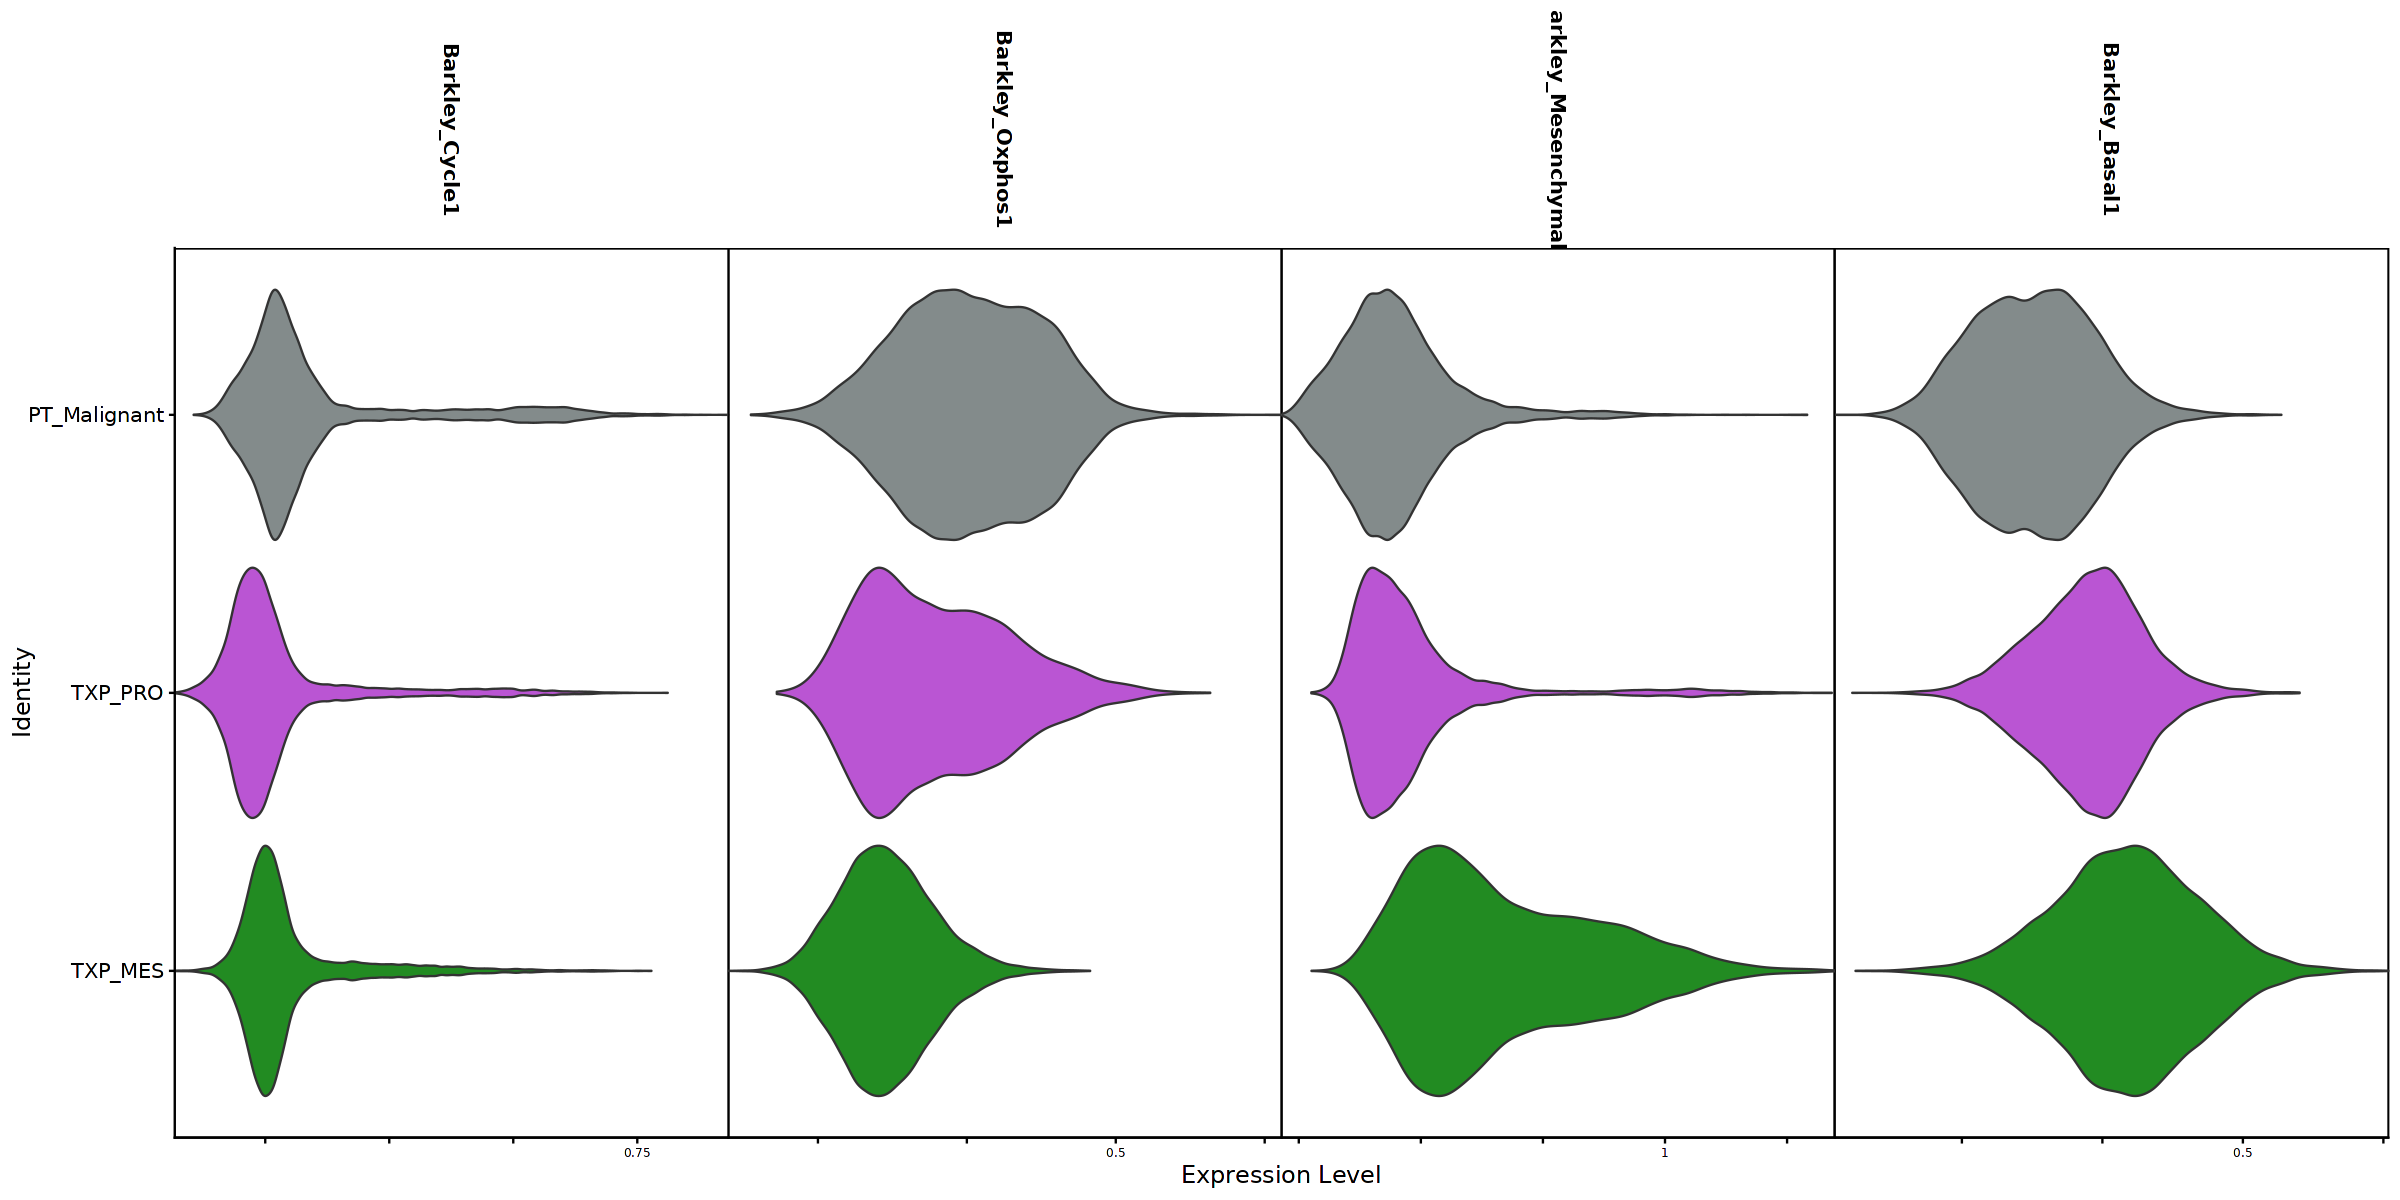

In [10]:
options(repr.plot.width=20, repr.plot.height=10)

modules = c("Barkley_Cycle1","Barkley_Oxphos1","Barkley_Mesenchymal1","Barkley_Basal1")
malignant.cells$source <- factor(x = malignant.cells$source, levels = c('TXP_MES','TXP_PRO','PT_Malignant'))

VlnPlot(malignant.cells, features = modules, pt.size = 0, stack=TRUE, group.by='source', flip=F,same.y.lims=F,
       fill.by='ident',cols=c("TXP_MES"="forestgreen","TXP_PRO"="mediumorchid","PT_Malignant"="azure4")) + NoLegend() #+ NoAxes()

# Fig 5h - METAFlux DotPlot

In [3]:
pro.flux$mean <- rowMeans(pro.flux[-1])
mes.flux$mean <- rowMeans(mes.flux[-1])
pt.flux$mean <- rowMeans(pt.flux[-1])

avg_flux <- pro.flux %>% select(mean)
avg_flux$MES <- mes.flux$mean
avg_flux$PT <- pt.flux$mean

names(avg_flux)[names(avg_flux) == 'mean'] <- 'PRO'

In [13]:
# Glucose = HMR_9034
# Acetates = HMR_9086
# Glutamine = HMR_9063
# Fatty Acids = HMR_9209
# D-lactate = HMR_9136

In [57]:
nutrient<-data.frame(glucose=avg_flux[grep("HMR_9034|HMR_9086|HMR_9063|HMR_9209|HMR_9135",rownames(avg_flux)),])

# cubic root normalization to normalize the scores
cbrt <- function(x) {
    sign(x) * abs(x)^(1/3)
}
nutrient=cbrt(nutrient)

nutrient$celltype=rownames(nutrient)


In [58]:
long_nutrient=reshape2::melt(nutrient,id.vars='celltype')
long_nutrient <- transform(long_nutrient, direction= ifelse(value<0, 'Consume', 'Release'))

In [59]:
long_nutrient <- long_nutrient[long_nutrient$celltype %like% "external_medium", ]
long_nutrient

,celltype,variable,value,direction
,<chr>,<fct>,<dbl>,<chr>
21,external_medium HMR_9034,glucose.PRO,-0.09476696,Consume
22,external_medium HMR_9063,glucose.PRO,-0.05550176,Consume
23,external_medium HMR_9086,glucose.PRO,0.05671716,Release
24,external_medium HMR_9135,glucose.PRO,0.12305391,Release
25,external_medium HMR_9209,glucose.PRO,0.14829723,Release
46,external_medium HMR_9034,glucose.MES,-0.12739839,Consume
47,external_medium HMR_9063,glucose.MES,-0.09231658,Consume
48,external_medium HMR_9086,glucose.MES,-0.06199190,Consume
49,external_medium HMR_9135,glucose.MES,0.14942847,Release


In [60]:
dot_plot <- ggplot(long_nutrient, aes(x=variable, y=celltype)) +
  geom_point(aes(size = abs(value), fill = direction), color="black", shape=21) +
  scale_size(name="Absolute Flux Score", range=c(2,8), limits=c(0,0.2)) +
  #scale_fill_gradientn(colours = viridisLite::mako(100),
  #                     guide = guide_colorbar(ticks.colour = "black",
  #                                            frame.colour = "black"),
  #                     name = "Average\nexpression") +
  ylab("") + xlab("") + 
  theme_bw() +
  theme(axis.text.x = element_text(size=10, angle=45, hjust=1, color="black"),
        axis.text.y = element_text(size=12, color="black"),
        axis.title = element_text(size=14),
       aspect.ratio = 0.9)

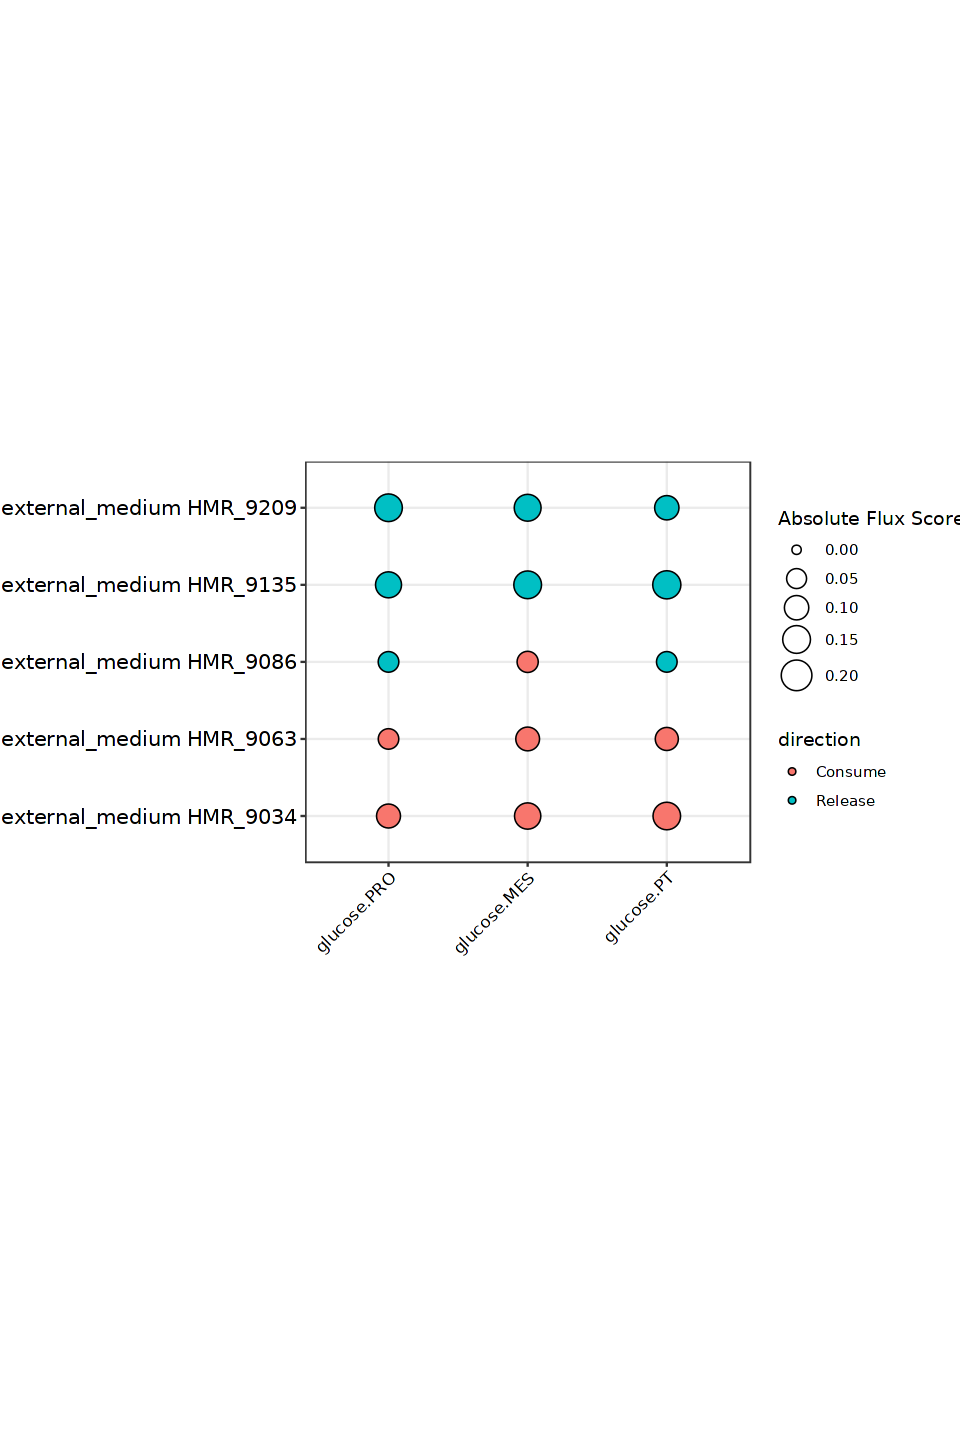

In [61]:
options(repr.plot.width=8, repr.plot.height=12)
dot_plot